In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## General Setup

In [7]:
noisy=False
weight_decay = 0.0004
optimizer = 'sgd'

## GradCAM

In [18]:
clean_intensities = {}
dirty_intensities = {}
distances = {}
concept_num = 0

for num_objects in [1,2,4]:
    train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy)
    val_images, val_y, val_c = unroll_data(val_loader)

    data_points = []
    binary_combos = list(itertools.product([0, 1], repeat=num_objects))
    for combo in binary_combos:
        as_tensor = []

        for k in combo:
            as_tensor.append(k)
            as_tensor.append(1-k)

        data_points.append(torch.where(torch.all(val_c == torch.Tensor(as_tensor), dim=1))[0][0].item())

    joint_model_small = get_synthetic_model(num_objects,'small3',noisy,weight_decay,optimizer)
    joint_model_large = get_synthetic_model(num_objects,'small7',noisy,weight_decay,optimizer)

    for method in [ plot_saliency,plot_gradcam,plot_integrated_gradients]:
        str_method = {plot_integrated_gradients: 'integrated gradients', plot_gradcam: 'gradcam',plot_saliency: 'saliency'}[method]

        print('{}_{}'.format(num_objects,str_method))
        clean_intensities['{}_{}'.format(num_objects,str_method)] = []
        dirty_intensities['{}_{}'.format(num_objects,str_method)] = []
        distances['{}_{}'.format(num_objects,str_method)] = []

        for i in data_points:
            gradcam_intensities_clean = method(joint_model_small,run_joint_model,concept_num,val_images,i,val_pkl,plot=False)
            gradcam_intensities_clean /= np.max(gradcam_intensities_clean)
            gradcam_intensities_clean -= np.min(gradcam_intensities_clean)
            clean_patches = get_patches(gradcam_intensities_clean,64)


            gradcam_intensities_dirty = method(joint_model_large,run_joint_model,concept_num,val_images,i,val_pkl,plot=False)
            gradcam_intensities_dirty -= np.min(gradcam_intensities_dirty)
            gradcam_intensities_dirty /= np.max(gradcam_intensities_dirty)
            dirty_patches = get_patches(gradcam_intensities_dirty,64)   

            clean_intensities['{}_{}'.format(num_objects,str_method)].append(np.sum(clean_patches[:,:2])/(np.sum(clean_patches)))
            dirty_intensities['{}_{}'.format(num_objects,str_method)].append(np.sum(dirty_patches[:,:2])/(np.sum(dirty_patches)))

            distances['{}_{}'.format(num_objects,str_method)].append(compute_wasserstein_distance(clean_patches,dirty_patches))
    print(clean_intensities)
    print(dirty_intensities)
    print(distances)


1_saliency
1_gradcam
1_integrated gradients
{'1_saliency': [0.9087328975479829, 0.7562588801493647], '1_gradcam': [0.4022380104528898, 0.6079678084958672], '1_integrated gradients': [0.48159536374041995, 0.5515293441799066]}
{'1_saliency': [0.9045956198010843, 0.8454416761210657], '1_gradcam': [0.13854956505791377, 0.7094645208601099], '1_integrated gradients': [0.4922226950636734, 0.5771661244520062]}
{'1_saliency': [0.1022848761002303, 0.019795693863516643], '1_gradcam': [0.45993918407279266, 0.18121352117671108], '1_integrated gradients': [0.001960099489841785, 0.03278438373461413]}
2_saliency
2_gradcam
2_integrated gradients
{'1_saliency': [0.9087328975479829, 0.7562588801493647], '1_gradcam': [0.4022380104528898, 0.6079678084958672], '1_integrated gradients': [0.48159536374041995, 0.5515293441799066], '2_saliency': [0.8923610030378948, 0.9067248035689448, 0.7342875669237627, 0.7650729436821389], '2_gradcam': [0.49999348366093144, 0.40288050334189646, 0.6052249271997894, 0.50830586

KeyboardInterrupt: 

In [9]:
gradcam_intensities_clean = method(joint_model_small,run_joint_model,concept_num,val_images,i,val_pkl,plot=False)
gradcam_intensities_clean /= np.max(gradcam_intensities_clean)
gradcam_intensities_clean -= np.min(gradcam_intensities_clean)
clean_patches = get_patches(gradcam_intensities_clean,64)


gradcam_intensities_dirty = method(joint_model_large,run_joint_model,concept_num,val_images,i,val_pkl,plot=False)
gradcam_intensities_dirty -= np.min(gradcam_intensities_dirty)
gradcam_intensities_dirty /= np.max(gradcam_intensities_dirty)

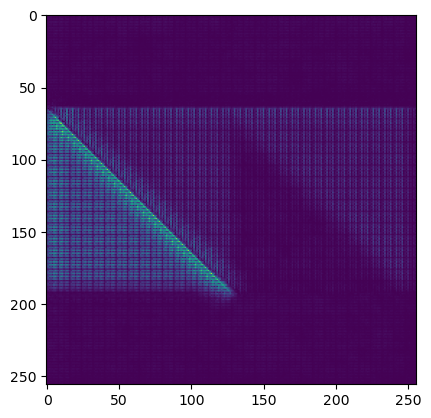

In [10]:
plt.imshow(gradcam_intensities_clean)

In [12]:
np.sum(clean_patches[:][:2])/(np.sum(clean_patches))

0.47487136505529387

In [15]:
clean_patches[:,:2]

array([[ 43.07473755,  37.72254562],
       [757.86077881, 271.42776489],
       [741.41467285, 663.60821533],
       [ 47.44445038,  53.08288956]])